# Detecting Features That Are Only Useful In Conjunction With Others

## The Problem

It is customary for practitioners to use as test for whether to include a feature $x_i$ in a regression or classification problem the extent to which it is informative about the label $y$ (e.g. its correlation, Spearman correlation, or even mutual information with its target). 

However, certain features are uninformative about the label (when used by themselves), but turn out to add a lot of predictive power when used in conjunction with others. Because these features fail the 'informativeness test', they are often unduly discarded, which could result in big opportunity costs.

In this case study we illustrate one such instance, and we showcase that the `kxy` package is able to detect features that are uninformative about the target, yet very useful when used alongside other explanatory variables.

We use the small UCI Bank Note dataset so that we may validate the findings of the `kxy` package using visual analyses. However, all conclusions extend to problems with far more explanatory variables/features. 

The goal in the UCI Bank Note experiment is to use properties of a picture of a bank note to determine whether the note is a forgery.

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["NUMEXPR_MAX_THREADS"] = '8'
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import pandas as pd
import kxy

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

## Selecting an Uninformative Feature
### Loading the Data


In [2]:
# Load the data using the kxy_datasets package (pip install kxy_datasets)
from kxy_datasets.uci_classifications import BankNote
df = BankNote().df

# Next, we normalize the data so that each input takes value in $[0, 1]$, so as to ease visualization. 
# All input importance analyses performed by the `kxy` package are robust to increasing transformations, 
# including the foregoing normalization. Nonetheless, we will take a copy of the data before normalization,
# which we will use for analyses, the normalized data being used for visualization only.
ef = df.copy() # Copy used for analysis.
# Normalization to ease vizualization
df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']] = \
    (df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']] - \
     df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']].min(axis=0))
df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']] /= \
    df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']].max(axis=0)

### Qualitative Selection
We begin by forming a qualitative/visual understanding of what features are informative about the target.

Intuitively, saying that an input $x_i$ is informative about a categorical label $y$ (when used in isolation) is the same as saying that observing the value of $x_i$ is useful for inferring the value of the label/class $y$. For this to be true, it ought to be the case that the collection of values of $x_i$ corresponding to a given value of $y$ should be sufficiently different from the collections of values of $x_i$ corresponding to the other classes. 

The more these collections are *different*, the less ambiguity there will be in inferring $y$ from $x_i$, and therefore the more useful $x_i$ will be for inferring $y$ in isolation.

In the case of the bank note dataset, for every one of the four inputs of interest, we can plot all values on the same line, and color each point red or green depending on whether the observed input came from a fake note or not. 

The more distinguishable the collection of red ticks is from the collection of green ticks, the more the corresponding input is useful at predicting whether or not a bank note is a forgery. 

Whenever red and green ticks are virtually undistinguishable, the corresponding feature is uninformative about the target.

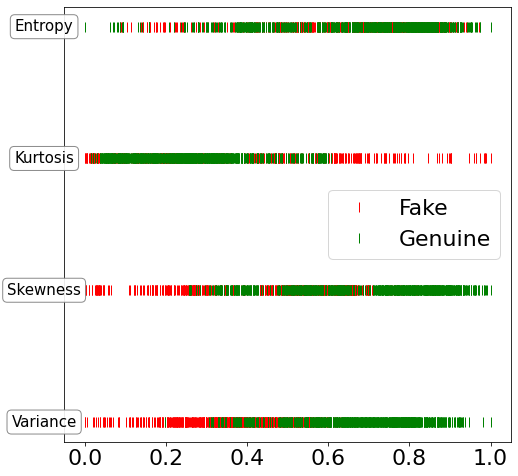

In [3]:
import pylab as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

y = df['Is Fake'].values.astype(bool)
v = df['Variance'].values
s = df['Skewness'].values
k = df['Kurtosis'].values
e = df['Entropy'].values

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
ax.plot(v[y], 0.0*np.ones_like(v[y]), '|', color='r', linewidth=2, markersize=10,\
        label='Fake')
ax.plot(v[~y], 0.0*np.ones_like(v[~y]), '|', color='g', linewidth=2, markersize=10,\
        label='Genuine')
ax.text(-0.1, 0, "Variance", ha="center", va="center", size=15, bbox=bbox_props)
ax.plot(s[y], 0.1*np.ones_like(s[y]), '|', color='r', linewidth=2, markersize=10)
ax.plot(s[~y], 0.1*np.ones_like(s[~y]), '|', color='g', linewidth=2, markersize=10)
ax.text(-0.1, 0.1, "Skewness", ha="center", va="center", size=15, bbox=bbox_props)
ax.plot(k[y], 0.2*np.ones_like(k[y]), '|', color='r', linewidth=2, markersize=10)
ax.plot(k[~y], 0.2*np.ones_like(k[~y]), '|', color='g', linewidth=2, markersize=10)
ax.text(-0.1, 0.2, "Kurtosis", ha="center", va="center", size=15, bbox=bbox_props)
ax.plot(e[y], 0.3*np.ones_like(e[y]), '|', color='r', linewidth=2, markersize=10)
ax.plot(e[~y], 0.3*np.ones_like(e[~y]), '|', color='g', linewidth=2, markersize=10)
ax.text(-0.1, 0.3, "Entropy", ha="center", va="center", size=15, bbox=bbox_props)
ax.axes.yaxis.set_visible(False)
plt.legend()
plt.show()

The plot above suggests that, of the 4 explanatory variables, `Entropy` is the least informative about the target. Let's confirm this by computing the highest performance achievable when using `Entropy` to predict the target.

## Validation That The Feature Is Uniformative 

In [4]:
ef[['Is Fake', 'Entropy']].kxy.variable_selection('Is Fake', problem_type='classification')

[====================================================================================================] 100% ETA: 0s    Duration: 1min


,Variable,Running Achievable R-Squared,Running Achievable Accuracy
Selection Order,,,
0,No Variable,0.00,0.56
1,Entropy,0.00,0.56


We do indeed see that, when used by itself, the `Entropy` variable provides no benefit over not using any explanatory variable at all. 

Can we however conclude that the `Entropy` variable is useless?

## Checking For Conditional Usefulness 
### Qualitatively

If `Entropy` is useless, then we would expect that adding it to any other explanatory variable should result in improved performance relative to using the other variable by itself. 

`Entropy` and `Variance` being measures of variability, we wouldn't expect them to complement each other a lot. To qualitatively determine whether `Entropy` can complement `Skewness` or `Kurtosis` in determining whether a bank note is fake, we plot our red and green dots on the two plans `Entropy` $\times$ `Skewness` and `Entropy` $\times$ `Kurtosis`. The idea is that, if red and green points are more distinguishable on these plans than they were on the `Skewness` and `Kurtosis` lines above, then `Entropy` should be expected to provide complementary value.

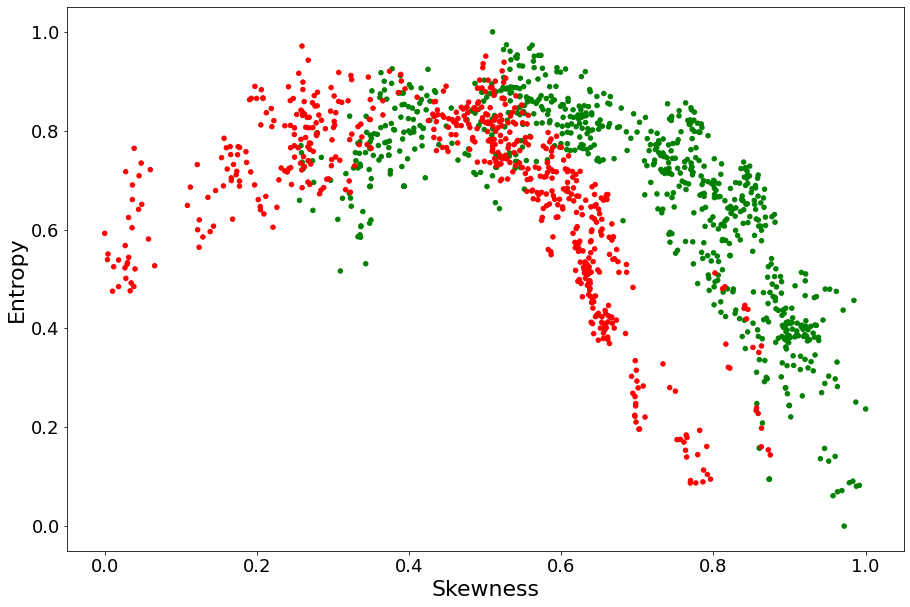

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
df.plot.scatter(ax=ax, x='Skewness', y='Entropy', c=df['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'), fontsize=18)
plt.show()

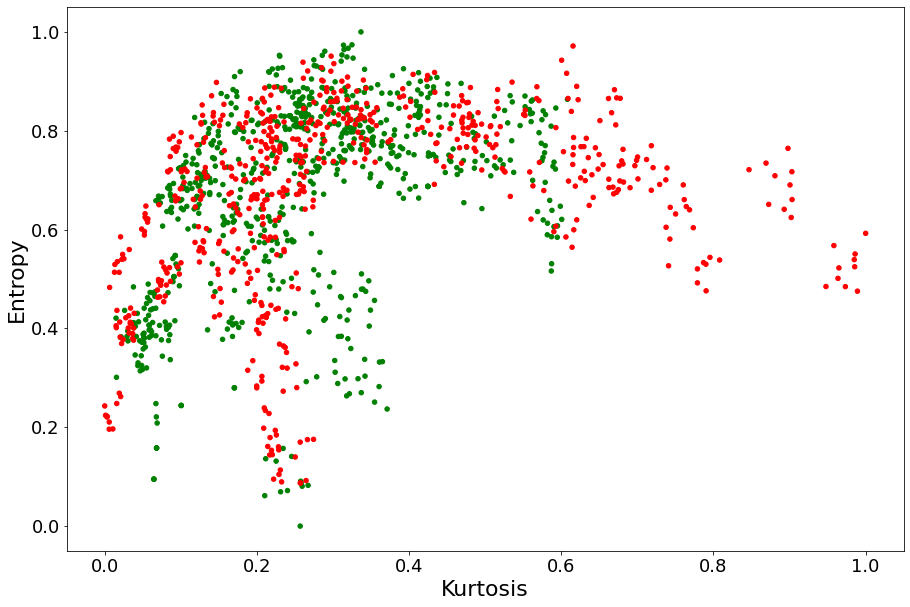

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
df.plot.scatter(ax=ax, x='Kurtosis', y='Entropy', c=df['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'), fontsize=18)
plt.show()

Clearly, `Entropy` seems to complement `Skewness` a lot more than `Kurtosis`. 

Let's check whether the `kxy` package can gauge this complementarity.

### Quantitatively

In [20]:
ef[['Is Fake', 'Entropy', 'Skewness']].kxy.variable_selection('Is Fake', problem_type='classification')

[====================================================================================================] 100% ETA: 0s    Duration: 22s


,Variable,Running Achievable R-Squared,Running Achievable Accuracy
Selection Order,,,
0,No Variable,0.00,0.56
1,Skewness,0.32,0.80
2,Entropy,0.61,0.94


Even though `Entropy` is uninformative about the target, the `kxy` package was able to detect that it can yield a 14% accuracy boost over simply using the `Skewness` variable! 

In such a small example, a qualitative analysis is possible to detect explanatory variables that are uniformative about the target but very useful when used in conjunction with others. 

However, when the number of explanatory variables is large, useful performance boost could simply be thrown away if we do not have a tool such as `kxy`.

In [21]:
ef[['Is Fake', 'Entropy', 'Kurtosis']].kxy.variable_selection('Is Fake', problem_type='classification')

[====================================================================================================] 100% ETA: 0s    Duration: 1min


,Variable,Running Achievable R-Squared,Running Achievable Accuracy
Selection Order,,,
0,No Variable,0.00,0.56
1,Kurtosis,0.03,0.60
2,Entropy,0.04,0.61


In [22]:
ef[['Is Fake', 'Entropy', 'Variance']].kxy.variable_selection('Is Fake', problem_type='classification')

[====================================================================================================] 100% ETA: 0s    Duration: 2min


,Variable,Running Achievable R-Squared,Running Achievable Accuracy
Selection Order,,,
0,No Variable,0.00,0.56
1,Variance,0.51,0.90
2,Entropy,0.59,0.93


As we expected from our qualitative analysis, `Entropy` indeed does not complement `Variance` or `Kurtosis` much.